<a href="https://colab.research.google.com/github/rodjfg/los-fabulosos-pixelotls/blob/master/glm_together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Left / Right model

In [ ]:
!pip install --quiet git+https://github.com/rodjfg/los-fabulosos-pixelotls

In [12]:
from los_fabulosos_pixelotls.tools import load_raw_data, select_by_areas, select_by_contrast, select_trials, calculate_mean_firing_rate, select_by_response
import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
# get data
alldat = load_raw_data()

In [9]:
selected_regions = ["VISp"]
gaussfilter = True
gauss_sigma = 1

samples = np.empty((0,250))
y = np.empty((0,))

for dat in alldat:
  dt = dat['bin_size']

  neurons_indices_in_area = select_by_areas(dat, selected_regions = selected_regions)

  if len(neurons_indices_in_area) > 0:

    right_response_trials = select_by_response(dat, response_type = 'to_left') # trials in which mouse should move to the left (higher contrast on right side)
    left_response_trials = select_by_response(dat, response_type = 'to_right') # trials in which mouse should move to the right (higher contrast on left side)

    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the left
    right_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,right_response_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)
    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the right
    left_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,left_response_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)

    # find minimum number of samples that can be extracted from both conditions
    n_min = min(right_firing_rates.shape[0],left_firing_rates.shape[0])
    samples = np.concatenate((samples,right_firing_rates[:n_min,...]),axis=0)
    samples = np.concatenate((samples,left_firing_rates[:n_min,...]),axis=0)

    # 1: mouse moved to the left, 0: mouse moved to the right
    y = np.concatenate( (y, np.ones(n_min)) )
    y = np.concatenate( (y, np.zeros(n_min)) )

In [11]:
y.shape, samples.shape

((2402,), (2402, 250))

TRAIN AND TEST SPLIT

In [13]:
samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.23, random_state=42)

In [21]:
# C: float, default=1.0, Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

# clf = LogisticRegressionCV(Cs=5, cv=4, penalty='l2', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
clf = LogisticRegression(penalty='l1', C =1.0, solver='saga', tol=0.0001, max_iter=8000, random_state=42).fit(samples_train, y_train)

In [22]:
clf.score(samples_test,y_test)

0.33815551537070526

In [23]:
clf.score(samples_train,y_train)

0.5484045429962142

In [26]:
clf = LogisticRegression(penalty='l2', C =0.5, solver='saga', tol=0.0001, max_iter=8000, random_state=42).fit(samples_train, y_train)
clf.score(samples_test,y_test)

0.33273056057866185

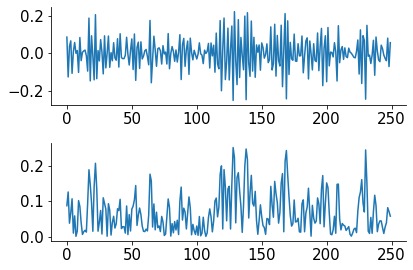

In [34]:
plt.subplot(211)
plt.plot(clf.coef_[0,:])
plt.subplot(212)
plt.plot(np.abs(clf.coef_[0,:]))
plt.show()